# IBM Creative Challenge

In [1]:
from qiskit import *

In [2]:
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts

In [3]:
backend = Aer.get_backend('qasm_simulator')

## Interference simple example
### Suppose we have a one-qubit circuit qc1.
### (1) Apply a hadamard gate to it. 
### $H|0\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle) = |+\rangle$
### At this time, the output probability should be either $|0\rangle$ or $|1\rangle$ with 50\%.
### (2) Apply another hadamard gate to it.
### $H|+\rangle = |0\rangle$
### The probability of $|0\rangle$ is increased because of the "constructive interference" and the probability of $|1\rangle$ is decreased because of "destructive interference".

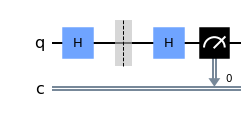

In [4]:
qc1 = QuantumCircuit(1,1)
qc1.h(0)
qc1.barrier()
qc1.h(0)
qc1.measure([0],[0])
qc1.draw(output='mpl')

In [5]:
job1 = execute(qc1, backend=backend)

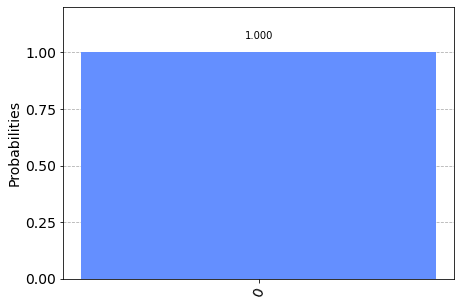

In [6]:
plot_histogram(job1.result().get_counts())

### Similarly, if we apply two hadamard gates to $|1\rangle$ state, the probability of $|1\rangle$ is constructively interfered.

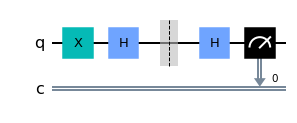

In [7]:
qc2 = QuantumCircuit(1,1)
qc2.x(0)
qc2.h(0)
qc2.barrier()
qc2.h(0)
qc2.measure([0],[0])
qc2.draw(output='mpl')

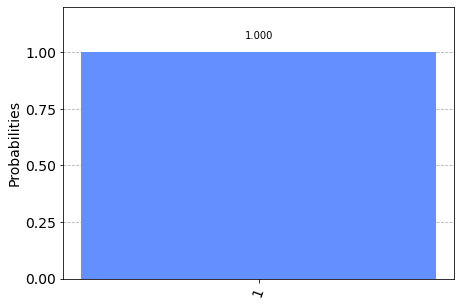

In [8]:
job2 = execute(qc2, backend=backend)
plot_histogram(job2.result().get_counts())

## Application of quantum interference -- Simon's algorithm
### 3-qubit example as in the qiskit textbook

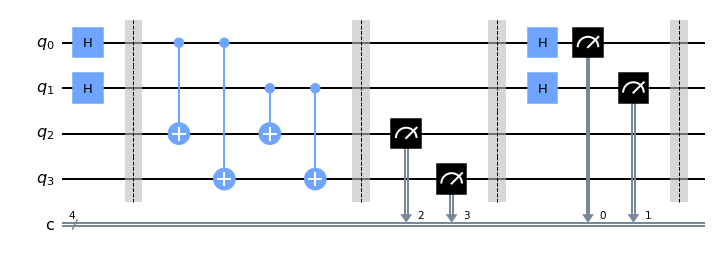

In [9]:
qc = QuantumCircuit(4,4)
qc.h(0)
qc.h(1)
qc.barrier()
qc.cx(0,2)
qc.cx(0,3)
qc.cx(1,2)
qc.cx(1,3)
qc.barrier()
qc.measure([2,3],[2,3])
qc.barrier()
qc.h(0)
qc.h(1)
qc.measure([0,1],[0,1])
qc.barrier()
qc.draw(output='mpl')

### After the first measurement of $q_2$ and $q_3$, the state of $|q_0q_1\rangle$ should be equally distributed as $|00\rangle, |01\rangle, |10\rangle, |11\rangle$.
### Interference happens after the second round of hadamard gates on $q_0, q_1$. The second measurement outcome of $q_0, q_1$ becomes either $|00\rangle$ or $|11\rangle$.


In [10]:
job = execute(qc, backend=Aer.get_backend('qasm_simulator'))

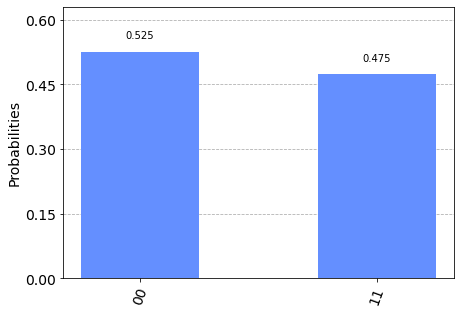

In [11]:
counts = marginal_counts(job.result(), indices=[0,1]).get_counts()
plot_histogram(counts)

# Conclusion
### Quantum interference is an important property in quantum computing. It can be observed in every quantum algorithm to make it solve problem faster, not only in simon's algorithm. For example, we can also see it in grover's algorithm to amplify the amplitude of the correct answer. 

## Application 2 - Implement based on "Joy Vazirani" and convert "Qiskit" to musical tone

In [3]:
n = 7 # number of qubits used to represent s

In [4]:
def wordToBV(s) :
    #convert text to binary
    a_byte_array = bytearray(s, "utf8")
    byte_list = []


    for byte in a_byte_array:
        binary_representation = bin(byte)
        byte_list.append(binary_representation[9-n:])
        #chop off the "0b" at the beginning. can also truncate the binary to fit on a device with N qubits
        #binary has 2 extra digits for "0b", so it starts at 9 for our 7 bit operation. 

    print(byte_list)
    
    circuit_array = []
    
    length = len(byte_list) 
    
    for i in range(length):
    
        s = byte_list[i]


        #do all  this stuff for every letter

        # We need a circuit with n qubits, plus one ancilla qubit
        # Also need n classical bits to write the output to
        bv_circuit = QuantumCircuit(n+1, n)

        # put ancilla in state |->
        bv_circuit.h(n)
        bv_circuit.z(n)

        # Apply Hadamard gates before querying the oracle
        for i in range(n):
            bv_circuit.h(i)

        # Apply barrier 
        bv_circuit.barrier()

        # Apply the inner-product oracle
        s = s[::-1] # reverse s to fit qiskit's qubit ordering
        for q in range(n):
            if s[q] == '0':
                bv_circuit.i(q)
            else:
                bv_circuit.cx(q, n)

        # Apply barrier 
        bv_circuit.barrier()

        #Apply Hadamard gates after querying the oracle
        for i in range(n):
            bv_circuit.h(i)

        # Measurement
        for i in range(n):
            bv_circuit.measure(i, i)
            
        circuit_array.append(bv_circuit)

    
    return circuit_array

In [38]:
circuit_to_run = wordToBV('Qiskit') # Output the result of "Qiskit"

['1010001', '1101001', '1110011', '1101011', '1101001', '1110100']


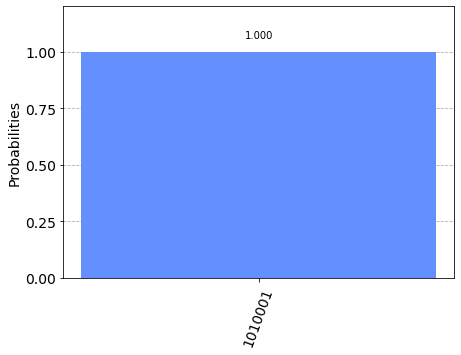

In [39]:
#run the first letter on a simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 4096
results = execute(circuit_to_run[0], backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

In [40]:
# Construct a noise model based on IBM Q Melbourne
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_16_melbourne')
noise_model = NoiseModel.from_backend(backend)
backend = QasmSimulator(method='density_matrix',
                        noise_model=noise_model)

ibmqfactory.load_account:WARNING:2021-04-11 14:08:51,944: Credentials are already in use. The existing account in the session will be replaced.


In [41]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
job = execute(circuit_to_run, backend=backend, noise_model=noise_model, shots=1024, max_credits=10)

In [42]:
results = job.result()
answers = results.get_counts()

In [44]:
# Write the results to a csv file
import csv
filename = 'raw_result.csv'
probs = []
for answer in answers:
    for key,value in answer.items():
        probs.append(value/1024)
        for _ in range(10): # Add zeros between each probability to prolong the tone
            probs.append(0)

with open(filename, 'w',newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ', quoting=csv.QUOTE_MINIMAL)
    for prob in probs:
        writer.writerow([prob])   